<a href="https://colab.research.google.com/github/JordanDCunha/Hands-On-Machine-Learning-with-Scikit-Learn-and-PyTorch/blob/main/Chapter_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 4: Training Models

So far, we have treated machine learning models and their training algorithms
mostly like black boxes. If you worked through the exercises in the previous
chapters, you may have been surprised by how much you could accomplish without
knowing what was happening under the hood.

You optimized a regression system, improved a digit image classifier, and even
built a spam classifier from scratch — all without understanding how these
models actually work. In many situations, this level of abstraction is
sufficient.


However, having a solid understanding of how models work internally can help
you:

- Quickly identify the most appropriate model for a task
- Choose the right training algorithm
- Select effective hyperparameters
- Debug issues and perform deeper error analysis

Understanding these fundamentals is also essential for neural networks, which
we will study in Part II of this book.


In this chapter, we will begin with **linear regression**, one of the simplest
machine learning models.

We will explore two very different ways to train it:

1. **Closed-form solution**
   - A mathematical equation that directly computes the model parameters
   - These parameters minimize the cost function over the training set

2. **Gradient Descent (GD)**
   - An iterative optimization algorithm
   - Gradually adjusts parameters to minimize the cost function
   - Eventually converges to the same solution as the closed-form method


We will also study several important variants of gradient descent that will
appear repeatedly throughout this book, especially in neural networks:

- Batch Gradient Descent
- Mini-batch Gradient Descent
- Stochastic Gradient Descent (SGD)


Next, we will move on to **polynomial regression**, a more flexible model capable
of fitting nonlinear datasets.

Because polynomial regression has more parameters than linear regression, it is
more prone to **overfitting**. We will learn how to:

- Detect overfitting using learning curves
- Reduce overfitting using regularization techniques


Finally, we will examine two widely used classification models:

- **Logistic Regression**
- **Softmax Regression**

These models are fundamental building blocks for many real-world classification
systems.


⚠️ **Warning: Math Ahead**

This chapter includes several mathematical equations involving:
- Vectors and matrices
- Transposition, multiplication, and inversion
- Partial derivatives

If these topics are unfamiliar, consider reviewing the introductory notebooks on
linear algebra and calculus provided in the online supplemental material.


If you are truly allergic to math, you can safely skip the equations — the
explanations will still convey most of the key ideas.

That said, learning the mathematical formalism is extremely valuable. It allows
you to:
- Understand why models behave the way they do
- Read and interpret machine learning research papers
- Debug and improve models more effectively

Although it may seem intimidating at first, it is not as difficult as it looks,
and the code examples in this chapter will help make the equations concrete.


# Linear Regression

In Chapter 1, we looked at a simple linear model of life satisfaction:

**Equation 4-1: A simple linear model of life satisfaction**

This model is a linear function of the input feature `GDP_per_capita`.
The parameters θ₀ and θ₁ are the model’s parameters.


More generally, a linear model makes a prediction by computing a weighted sum
of the input features, plus a constant called the **bias term**
(or **intercept**), as shown below.

**Equation 4-2: Linear regression model prediction**

ŷ = θ₀ + θ₁x₁ + θ₂x₂ + ⋯ + θₙxₙ


Where:
- ŷ is the predicted value
- n is the number of features
- xᵢ is the i-th feature value
- θⱼ is the j-th model parameter


This can be written more concisely using vector notation.

**Equation 4-3: Linear regression (vectorized form)**

ŷ = h_θ(x) = θ · x


In this notation:
- h_θ is the hypothesis function
- θ is the parameter vector (including θ₀)
- x is the feature vector, with x₀ = 1
- θ · x is the dot product


### Note on Vector Notation

In machine learning, vectors are often represented as **column vectors**.
When θ and x are column vectors, predictions are written as:

ŷ = θᵀx

This is mathematically equivalent to the dot product, but written using
matrix multiplication.


### Training a Linear Regression Model

Training a model means finding the parameter vector θ that best fits
the training data.

For regression tasks, the most common performance measure is the
**Root Mean Squared Error (RMSE)**.

In practice, we minimize the **Mean Squared Error (MSE)** instead,
since it leads to the same solution and is easier to optimize.


⚠️ **Warning**

Training loss and evaluation metrics are often different.

- Training loss: easy to optimize (e.g., MSE, log loss)
- Evaluation metric: aligned with business goals (e.g., RMSE, precision/recall)

A good training loss is easy to minimize and strongly correlated
with the evaluation metric.


### Mean Squared Error (MSE)

**Equation 4-4: MSE cost function**

MSE(θ) = (1 / m) Σ (h_θ(x⁽ⁱ⁾) − y⁽ⁱ⁾)²

We write MSE(θ) to emphasize that the model depends on θ.


## The Normal Equation

The value of θ that minimizes the MSE can be found using a closed-form solution
called the **normal equation**.

**Equation 4-5: Normal equation**

θ̂ = (XᵀX)⁻¹ Xᵀ y


import numpy as np

rng = np.random.default_rng(seed=42)
m = 200  # number of instances
X = 2 * rng.random((m, 1))
y = 4 + 3 * X + rng.standard_normal((m, 1))


Figure 4-1 shows a randomly generated linear dataset.


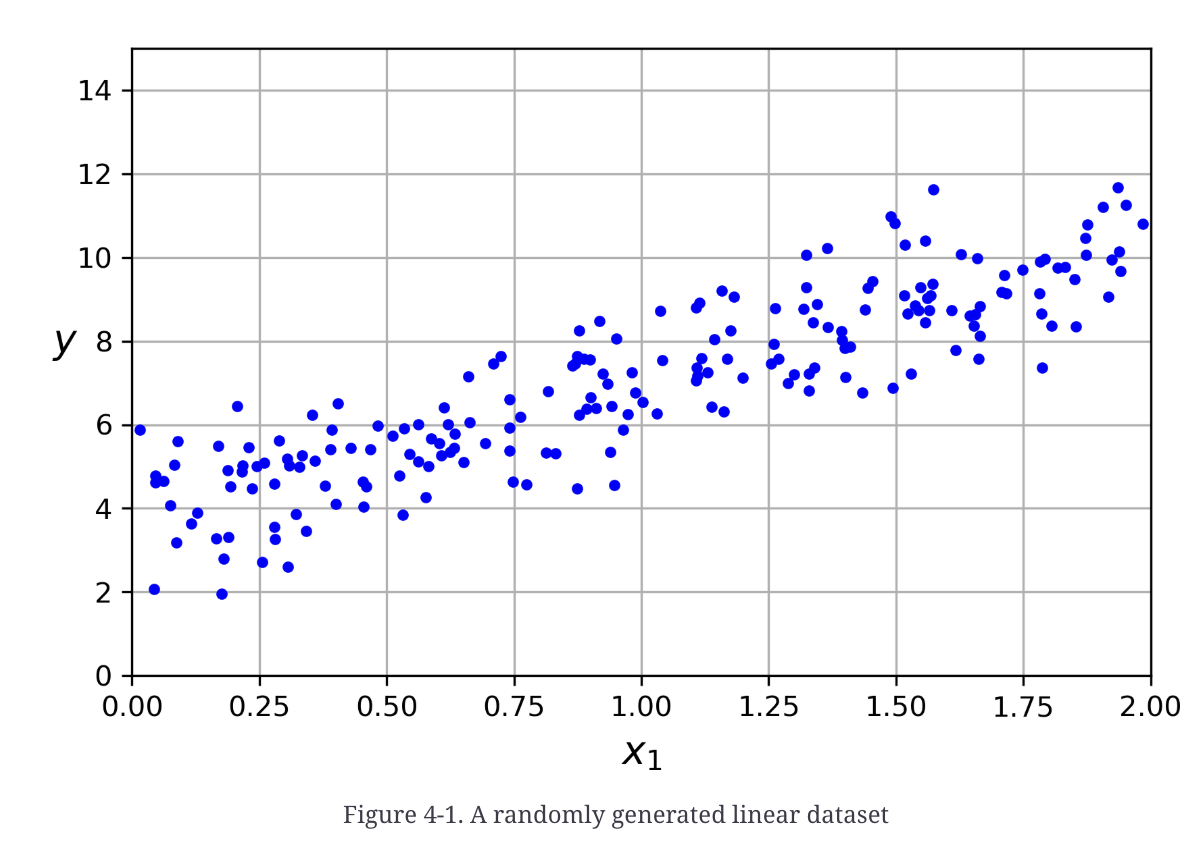

In [ ]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # add x0 = 1
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
theta_best


Because the data contains noise, the recovered parameters are close to,
but not exactly equal to, the original values (θ₀ = 4, θ₁ = 3).


In [ ]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)
y_predict = X_new_b @ theta_best
y_predict


In [ ]:
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.", label="Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


# Linear Regression with Scikit-Learn


In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

lin_reg.intercept_, lin_reg.coef_


In [ ]:
lin_reg.predict(X_new)


Scikit-Learn separates the bias term (`intercept_`) from the feature weights
(`coef_`).

Internally, `LinearRegression` uses a least-squares solver based on SVD.


In [ ]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd


In [ ]:
np.linalg.pinv(X_b) @ y


The pseudoinverse is computed using **Singular Value Decomposition (SVD)**,
which is more numerically stable and works even when XᵀX is not invertible.


## Computational Complexity

- Normal Equation: O(n²·⁴) to O(n³)
- SVD (used by Scikit-Learn): O(n²)

Both scale linearly with the number of training instances (O(m)).


Predictions are very fast once the model is trained:
time complexity is linear in both the number of instances and features.


Next, we will explore a very different approach to training linear regression:
**Gradient Descent**, which is better suited for very large datasets.


# Gradient Descent

Gradient descent is a generic optimization algorithm capable of finding
optimal solutions to a wide range of problems. The general idea is to tweak
model parameters iteratively in order to minimize a cost function.


Imagine you are lost in the mountains in a dense fog and can only feel the
slope of the ground below your feet. A good strategy to reach the bottom
quickly is to go downhill in the direction of the steepest slope.

This is exactly what gradient descent does: it measures the local gradient
of the error function with respect to the parameter vector θ and moves in
the direction of the steepest descent. Once the gradient is zero, a minimum
has been reached.


In practice, gradient descent works as follows:

1. Initialize the parameters θ randomly
2. Compute the gradient of the cost function
3. Take a small step in the opposite direction of the gradient
4. Repeat until convergence


In practice, gradient descent works as follows:

1. Initialize the parameters θ randomly
2. Compute the gradient of the cost function
3. Take a small step in the opposite direction of the gradient
4. Repeat until convergence


### Learning Rate

The **learning rate** (η) controls the size of each step.

- Too small → very slow convergence
- Too large → may overshoot and diverge


Not all cost functions are nice and smooth. They may contain local minima,
plateaus, ridges, or steep cliffs.

Fortunately, the Mean Squared Error (MSE) cost function used for linear
regression is **convex**, meaning it has a single global minimum.
Gradient descent is guaranteed to converge (with a reasonable learning rate).


### Feature Scaling

When features have very different scales, gradient descent converges much
more slowly. This is why feature scaling (e.g., standardization) is important
when using gradient descent.


⚠️ **Warning**

Always scale your features (e.g., with `StandardScaler`) before using
gradient descent, or convergence may be extremely slow.


## Batch Gradient Descent

To apply gradient descent, we compute the gradient of the cost function with
respect to each parameter θⱼ. This is done using partial derivatives.


**Equation 4-6: Partial derivative of the MSE**

∂MSE(θ) / ∂θⱼ = (2 / m) Σ (h_θ(x⁽ⁱ⁾) − y⁽ⁱ⁾) xⱼ⁽ⁱ⁾


Instead of computing each partial derivative separately, we can compute the
entire gradient vector at once.

**Equation 4-7: Gradient vector**

∇θMSE(θ) = (2 / m) Xᵀ (Xθ − y)


Batch gradient descent uses the **entire training set** to compute the
gradient at every step. This makes it slow for very large datasets, but
efficient when the number of features is large.


**Equation 4-8: Gradient descent update rule**

θ ← θ − η ∇θMSE(θ)


In [ ]:
eta = 0.1  # learning rate
n_epochs = 1000
m = len(X_b)

rng = np.random.default_rng(seed=42)
theta = rng.standard_normal((2, 1))  # random initialization

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

theta


Batch gradient descent converges to the same solution as the normal equation,
provided the learning rate is chosen appropriately.


Choosing the learning rate:

- Too small → very slow training
- Too large → divergence
- Just right → fast convergence


To stop training automatically, you can use **early stopping**:
terminate training when the gradient norm becomes smaller than a small
tolerance ε.


## Stochastic Gradient Descent (SGD)

Batch gradient descent is slow for large datasets because it uses the entire
training set at every step.

Stochastic Gradient Descent (SGD) solves this by using **only one random
instance per step**.


Advantages:
- Extremely fast iterations
- Supports out-of-core learning
- Can escape local minima

Disadvantages:
- Noisy updates
- Never fully settles at the minimum


To address instability, the learning rate is gradually reduced using a
**learning schedule**.


In [ ]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule parameters

def learning_schedule(t):
    return t0 / (t + t1)

rng = np.random.default_rng(seed=42)
theta = rng.standard_normal((2, 1))

for epoch in range(n_epochs):
    for iteration in range(m):
        random_index = rng.integers(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients

theta


SGD converges near the minimum but continues to bounce around it due to
random sampling.


⚠️ **Important**

Training data must be independent and identically distributed (IID).
Always shuffle training instances to avoid biased updates.


### SGD with Scikit-Learn


In [ ]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(
    max_iter=1000,
    tol=1e-5,
    penalty=None,
    eta0=0.01,
    n_iter_no_change=100,
    random_state=42
)

sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_


Scikit-Learn’s `SGDRegressor` reaches a solution very close to the one found
using the normal equation.


### Tip

Some estimators support:
- `partial_fit()` for incremental learning
- `warm_start=True` to resume training

These are useful when training large models or streaming data.


## Mini-Batch Gradient Descent

Mini-batch gradient descent is a compromise between batch GD and SGD.

At each step, it computes gradients using small random batches of instances.


Advantages:
- Faster than batch GD
- More stable than SGD
- Efficient on GPUs and vectorized hardware


Mini-batch GD converges close to the minimum but continues to fluctuate
slightly. With a good learning schedule, it performs very well in practice.


### Summary

All gradient descent variants eventually learn very similar models.
They differ mainly in speed, memory usage, and training stability.


# Polynomial Regression

What if your data is more complex than a straight line? Surprisingly, you can
still use a linear model to fit nonlinear data.

The idea is to add powers of each feature as new features, then train a linear
model on this extended feature set. This technique is called **polynomial
regression**.


Let’s look at an example. We will generate nonlinear data based on a quadratic
equation of the form:

y = ax² + bx + c

and add some Gaussian noise.


In [ ]:
import numpy as np

rng = np.random.default_rng(seed=42)
m = 200  # number of instances
X = 6 * rng.random((m, 1)) - 3
y = 0.5 * X**2 + X + 2 + rng.standard_normal((m, 1))


This dataset is clearly nonlinear, so a straight line will not fit it properly.


To allow a linear model to fit nonlinear data, we transform the features by
adding polynomial terms. Scikit-Learn provides the `PolynomialFeatures` class
for this purpose.


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)


Let’s compare the original features with the transformed polynomial features.


In [ ]:
X[0]


In [ ]:
X_poly[0]


`X_poly` now contains:
- the original feature x
- the square of the feature x²

We can now train a standard linear regression model on this extended feature
set.


In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_


The model has learned parameters close to the original data-generating
function:

Original:
y = 0.5x² + 1x + 2

Learned:
≈ 0.505x² + 1.11x + 2.01


Even though the model is linear in its parameters, the feature transformation
allows it to model nonlinear relationships.


### Feature Interactions

When there are multiple input features, polynomial regression can also capture
**interactions between features**.

For example, with two features a and b, a polynomial of degree 3 will include:
- a², a³
- b², b³
- ab, a²b, ab²

This allows the model to learn relationships that plain linear regression
cannot represent.


⚠️ **Warning: Feature Explosion**

`PolynomialFeatures(degree=d)` transforms n input features into:

(n + d)! / (d! n!) features

This number grows extremely fast. High-degree polynomials with many features
can quickly become computationally infeasible and lead to severe overfitting.


# Learning Curves

High-degree polynomial regression can fit the training data much better than a
simple linear model, but this often comes at the cost of **overfitting**.

For example, a very high-degree polynomial may wiggle excessively to pass
through as many training points as possible, while a linear model may fail to
capture the true structure of the data.


So how can we tell whether a model is underfitting or overfitting?

One useful diagnostic tool is **learning curves**. Learning curves plot the
model’s training error and validation error as a function of the number of
training instances.


So how can we tell whether a model is underfitting or overfitting?

One useful diagnostic tool is **learning curves**. Learning curves plot the
model’s training error and validation error as a function of the number of
training instances.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve


Let’s start by plotting the learning curves for a **plain linear regression**
model.


In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(),
    X,
    y,
    train_sizes=np.linspace(0.01, 1.0, 40),
    cv=5,
    scoring="neg_root_mean_squared_error"
)

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="Training error")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="Validation error")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.show()


### Interpreting the Linear Model Learning Curves

This model is **underfitting** the data.

- The training error quickly reaches a plateau.
- The validation error also plateaus at a similar (high) value.
- Both curves are close together and fairly high.

This indicates that the model is too simple to capture the underlying structure
of the data.


💡 **Tip**

If your model is underfitting, adding more training data will not help.
You need a more complex model or better features.


Now let’s look at the learning curves for a **10th-degree polynomial regression**
model on the same dataset.


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression()
)


In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression,
    X,
    y,
    train_sizes=np.linspace(0.01, 1.0, 40),
    cv=5,
    scoring="neg_root_mean_squared_error"
)

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="Training error")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="Validation error")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.show()


### Interpreting the Polynomial Model Learning Curves

These curves reveal **overfitting**:

- The training error is much lower than before.
- There is a noticeable gap between training and validation error.
- The model performs significantly better on the training data than on unseen
  data.

With enough training data, the validation curve would slowly approach the
training curve.


## The Bias–Variance Trade-Off

A model’s generalization error can be decomposed into three components:


### Bias
Error due to incorrect assumptions about the data (e.g., assuming linearity
when the true relationship is quadratic). High bias leads to underfitting.


### Variance
Error due to excessive sensitivity to small changes in the training data.
High-variance models (like high-degree polynomials) tend to overfit.


### Irreducible Error
Error caused by noise in the data itself. This cannot be eliminated by any
model and can only be reduced by improving data quality.


Increasing model complexity typically:
- Decreases bias
- Increases variance

Reducing model complexity or adding regularization:
- Increases bias
- Decreases variance

This balance is known as the **bias–variance trade-off**.


💡 **Tip**

One way to reduce overfitting is to provide more training data, allowing the
validation error to approach the training error.


# Regularized Linear Models

A common way to reduce overfitting is to **regularize** a model — that is, to
constrain it so it has fewer degrees of freedom.

Regularization discourages overly complex models by penalizing large weights.
This stabilizes training and improves generalization.


Linear regression already seems simple, but it can still overfit when:
- Features are nearly colinear
- The dataset is noisy
- The number of features is large

Regularization helps make linear models more robust and numerically stable.


In this section, we will cover three common regularized linear models:

- Ridge Regression (ℓ2 regularization)
- Lasso Regression (ℓ1 regularization)
- Elastic Net Regression (ℓ1 + ℓ2 regularization)


## Ridge Regression

Ridge regression (also called Tikhonov regularization) adds a penalty equal to the
square of the ℓ2 norm of the weight vector to the MSE loss.

This encourages the model to keep weights small, reducing variance and
preventing overfitting.


The regularization strength is controlled by the hyperparameter α:

- α = 0 → ordinary linear regression
- Large α → weights shrink toward zero, predictions become flatter


⚠️ Important:
Ridge regression is sensitive to feature scale.
Always scale the data (e.g., using `StandardScaler`) before training.


In [ ]:
from sklearn.linear_model import Ridge


In [ ]:
ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])


Ridge regression can also be trained using stochastic gradient descent.


In [ ]:
from sklearn.linear_model import SGDRegressor

m = len(X)

sgd_reg = SGDRegressor(
    penalty="l2",
    alpha=0.1 / m,
    tol=None,
    max_iter=1000,
    eta0=0.01,
    random_state=42
)

sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])


💡 Tip:
`RidgeCV` automatically tunes the α hyperparameter using cross-validation and is
much faster than a generic grid search.


## Lasso Regression

Lasso regression uses ℓ1 regularization, adding the sum of the absolute values
of the weights to the loss function.


A key property of lasso regression is **sparsity**:

- It tends to set less important feature weights exactly to zero
- This effectively performs automatic feature selection


Increasing α increases sparsity, but too much regularization can severely harm
performance.


In [ ]:
from sklearn.linear_model import Lasso


In [ ]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])


⚠️ Note:
Lasso optimization is slower than ridge because the ℓ1 loss is not differentiable
at zero. Gradient descent may bounce around near the optimum.


## Elastic Net Regression

Elastic Net combines ridge and lasso regularization.

Its penalty is a weighted sum of ℓ1 and ℓ2 terms.


The mix ratio r controls the balance:
- r = 0 → Ridge regression
- r = 1 → Lasso regression


In [ ]:
from sklearn.linear_model import ElasticNet


In [ ]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])


💡 Recommendation:

- Avoid plain linear regression
- Use ridge as a safe default
- Use lasso or elastic net when feature selection matters
- Prefer elastic net when features are correlated or when features > samples


## Early Stopping

Early stopping is a powerful regularization technique for iterative algorithms
such as gradient descent.

Training stops when validation error stops improving.


As training progresses:
- Training error keeps decreasing
- Validation error eventually increases → overfitting begins

Early stopping halts training at the validation minimum.


In [ ]:
from copy import deepcopy
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor


In [ ]:
# Assume the dataset has already been split
# X_train, y_train, X_valid, y_valid = ...

preprocessing = make_pipeline(
    PolynomialFeatures(degree=90, include_bias=False),
    StandardScaler()
)

X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)

sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)

n_epochs = 500
best_valid_rmse = float("inf")
best_model = None

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_pred = sgd_reg.predict(X_valid_prep)
    val_rmse = root_mean_squared_error(y_valid, y_valid_pred)

    if val_rmse < best_valid_rmse:
        best_valid_rmse = val_rmse
        best_model = deepcopy(sgd_reg)


This approach does not stop training early, but it allows you to roll back to
the best-performing model after training completes.

`deepcopy()` is required to preserve learned parameters.


# Logistic Regression

Logistic regression is commonly used for **binary classification**.
It estimates the probability that an instance belongs to a particular class.

If the estimated probability exceeds a threshold (typically 50%),
the instance is classified as the positive class (1); otherwise as the
negative class (0).


Despite its name, logistic regression is a **classification** algorithm.

It models probabilities using a sigmoid (logistic) function applied
to a linear model.


## Estimating Probabilities

Like linear regression, logistic regression computes a weighted sum of
features plus a bias term.

Instead of outputting this value directly, it applies the logistic
(sigmoid) function.


The logistic (sigmoid) function maps any real number to a value between 0 and 1.

This allows the output to be interpreted as a probability.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def sigmoid(t):
    return 1 / (1 + np.exp(-t))

t = np.linspace(-10, 10, 400)
plt.plot(t, sigmoid(t))
plt.xlabel("t")
plt.ylabel("σ(t)")
plt.grid(True)
plt.show()


Using a 50% threshold:
- σ(t) ≥ 0.5 when t ≥ 0 → predict class 1
- σ(t) < 0.5 when t < 0 → predict class 0


The value t = θᵀx is called the **logit** (or log-odds).

The inverse of the sigmoid is:
logit(p) = log(p / (1 − p))


## Training and Cost Function

The goal of training is to estimate high probabilities for positive
instances and low probabilities for negative ones.


Logistic regression uses **log loss** as its cost function.

This loss heavily penalizes confident but wrong predictions.


There is no closed-form solution for logistic regression.

However, the cost function is **convex**, so gradient descent is guaranteed
to find the global minimum.


The gradient of the loss resembles linear regression:
prediction error × feature value, averaged over all instances.


## Decision Boundaries

We will use the Iris dataset to build a classifier that detects
Iris virginica using petal width.


In [ ]:
from sklearn.datasets import load_iris


In [ ]:
iris = load_iris(as_frame=True)
iris.data.head()


Target labels:
- 0 → setosa
- 1 → versicolor
- 2 → virginica


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [ ]:
X = iris.data[["petal width (cm)"]].values
y = (iris.target_names[iris.target] == "virginica")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)


Let’s examine predicted probabilities for petal widths between 0 and 3 cm.


In [ ]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)


In [ ]:
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not virginica")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Virginica")
plt.axvline(decision_boundary, color="k", linestyle=":", label="Decision boundary")

plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.show()


The decision boundary occurs where both class probabilities equal 50%.

Above the boundary → predict Iris virginica
Below the boundary → predict not virginica


In [ ]:
decision_boundary


In [ ]:
log_reg.predict([[1.7], [1.5]])


Logistic regression produces a **linear decision boundary** in feature space.


⚠️ Regularization note:
LogisticRegression uses **C**, the inverse of regularization strength.

- Larger C → less regularization
- Smaller C → more regularization


## Softmax Regression

Softmax regression generalizes logistic regression to handle multiple classes
directly.


For each class k, the model computes a score:

sₖ(x) = θₖᵀx


These scores are converted to probabilities using the **softmax function**.


The softmax function exponentiates and normalizes the scores so that
all probabilities sum to 1.


The predicted class is simply the one with the highest probability.


Softmax regression is suitable only for **mutually exclusive classes**.


The training loss is **cross entropy**, which penalizes low probability
assigned to the true class.


In [ ]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)


In [ ]:
softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)


In [ ]:
softmax_reg.predict([[5, 2]])


In [ ]:
softmax_reg.predict_proba([[5, 2]]).round(2)


Even when no class exceeds 50% probability, softmax regression still predicts
the most likely class.


Decision boundaries between classes are linear, but probability contours are
curved.


## Chapter Summary

In this chapter, you learned:

- Linear regression via closed-form and gradient descent
- Polynomial regression and learning curves
- Bias–variance trade-off
- Regularization: ridge, lasso, elastic net
- Early stopping
- Logistic regression for binary classification
- Softmax regression for multiclass classification

We’ve officially opened the first machine learning black boxes.


# Exercise solutions

## 1. to 11.

1. If you have a training set with millions of features you can use Stochastic Gradient Descent or Mini-batch Gradient Descent, and perhaps Batch Gradient Descent if the training set fits in memory. But you cannot use the Normal Equation or the SVD approach because the computational complexity grows quickly (more than quadratically) with the number of features.
2. If the features in your training set have very different scales, the cost function will have the shape of an elongated bowl, so the Gradient Descent algorithms will take a long time to converge. To solve this you should scale the data before training the model. Note that the Normal Equation or SVD approach will work just fine without scaling. Moreover, regularized models may converge to a suboptimal solution if the features are not scaled: since regularization penalizes large weights, features with smaller values will tend to be ignored compared to features with larger values.
3. Gradient Descent cannot get stuck in a local minimum when training a Logistic Regression model because the cost function is convex. _Convex_ means that if you draw a straight line between any two points on the curve, the line never crosses the curve.
4. If the optimization problem is convex (such as Linear Regression or Logistic Regression), and assuming the learning rate is not too high, then all Gradient Descent algorithms will approach the global optimum and end up producing fairly similar models. However, unless you gradually reduce the learning rate, Stochastic GD and Mini-batch GD will never truly converge; instead, they will keep jumping back and forth around the global optimum. This means that even if you let them run for a very long time, these Gradient Descent algorithms will produce slightly different models.
5. If the validation error consistently goes up after every epoch, then one possibility is that the learning rate is too high and the algorithm is diverging. If the training error also goes up, then this is clearly the problem and you should reduce the learning rate. However, if the training error is not going up, then your model is overfitting the training set and you should stop training.
6. Due to their random nature, neither Stochastic Gradient Descent nor Mini-batch Gradient Descent is guaranteed to make progress at every single training iteration. So if you immediately stop training when the validation error goes up, you may stop much too early, before the optimum is reached. A better option is to save the model at regular intervals; then, when it has not improved for a long time (meaning it will probably never beat the record), you can revert to the best saved model.
7. Stochastic Gradient Descent has the fastest training iteration since it considers only one training instance at a time, so it is generally the first to reach the vicinity of the global optimum (or Mini-batch GD with a very small mini-batch size). However, only Batch Gradient Descent will actually converge, given enough training time. As mentioned, Stochastic GD and Mini-batch GD will bounce around the optimum, unless you gradually reduce the learning rate.
8. If the validation error is much higher than the training error, this is likely because your model is overfitting the training set. One way to try to fix this is to reduce the polynomial degree: a model with fewer degrees of freedom is less likely to overfit. Another thing you can try is to regularize the model—for example, by adding an ℓ₂ penalty (Ridge) or an ℓ₁ penalty (Lasso) to the cost function. This will also reduce the degrees of freedom of the model. Lastly, you can try to increase the size of the training set.
9. If both the training error and the validation error are almost equal and fairly high, the model is likely underfitting the training set, which means it has a high bias. You should try reducing the regularization hyperparameter _α_.
10. Let's see:
  * A model with some regularization typically performs better than a model without any regularization, so you should generally prefer Ridge Regression over plain Linear Regression.
  * Lasso Regression uses an ℓ₁ penalty, which tends to push the weights down to exactly zero. This leads to sparse models, where all weights are zero except for the most important weights. This is a way to perform feature selection automatically, which is good if you suspect that only a few features actually matter. When you are not sure, you should prefer Ridge Regression.
  * Elastic Net is generally preferred over Lasso since Lasso may behave erratically in some cases (when several features are strongly correlated or when there are more features than training instances). However, it does add an extra hyperparameter to tune. If you want Lasso without the erratic behavior, you can just use Elastic Net with an `l1_ratio` close to 1.
11. If you want to classify pictures as outdoor/indoor and daytime/nighttime, since these are not exclusive classes (i.e., all four combinations are possible) you should train two Logistic Regression classifiers.

## 12. Batch Gradient Descent with early stopping for Softmax Regression
Exercise: _Implement Batch Gradient Descent with early stopping for Softmax Regression without using Scikit-Learn, only NumPy. Use it on a classification task such as the iris dataset._

Let's start by loading the data. We will just reuse the Iris dataset we loaded earlier.

In [ ]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"].values

We need to add the bias term for every instance ($x_0 = 1$). The easiest option to do this would be to use Scikit-Learn's `add_dummy_feature()` function, but the point of this exercise is to get a better understanding of the algorithms by implementing them manually. So here is one possible implementation:

In [ ]:
X_with_bias = np.c_[np.ones(len(X)), X]

The easiest option to split the dataset into a training set, a validation set and a test set would be to use Scikit-Learn's `train_test_split()` function, but again, we want to do it manually:

In [ ]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rng = np.random.default_rng(seed=42)
rnd_indices = rng.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for any given instance is a one-hot vector). Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance. To understand this code, you need to know that `np.diag(np.ones(n))` creates an n×n matrix full of 0s except for 1s on the main diagonal. Moreover, if `a` is a NumPy array, then `a[[1, 3, 2]]` returns an array with 3 rows equal to `a[1]`, `a[3]` and `a[2]` (this is [advanced NumPy indexing](https://numpy.org/doc/stable/user/basics.indexing.html#advanced-indexing)).

In [ ]:
def to_one_hot(y):
    return np.diag(np.ones(y.max() + 1))[y]

Let's test this function on the first 10 instances:

In [ ]:
y_train[:10]

array([1, 1, 2, 0, 2, 2, 1, 2, 2, 0])

In [ ]:
to_one_hot(y_train[:10])

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

Looks good, so let's create the target class probabilities matrix for the training set and the test set:

In [ ]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

Now let's scale the inputs. We compute the mean and standard deviation of each feature on the training set (except for the bias feature), then we center and scale each feature in the training set, the validation set, and the test set:

In [ ]:
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)
X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std

Now let's implement the Softmax function. Recall that it is defined by the following equation:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [ ]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = exps.sum(axis=1, keepdims=True)
    return exps / exp_sums

We are almost ready to start training. Let's define the number of inputs and outputs:

In [ ]:
n_inputs = X_train.shape[1]  # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))  # == 3 (there are 3 iris classes)

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.

So the equations we will need are the cost function:

$J(\mathbf{\Theta}) = - \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.

In [ ]:
eta = 0.5  # learning rate
n_epochs = 5001
m = len(X_train)  # number of instances
epsilon = 1e-5

rng = np.random.default_rng(seed=42)
Theta = rng.standard_normal((n_inputs, n_outputs))

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        print(epoch, xentropy_losses.sum(axis=1).mean())
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    Theta = Theta - eta * gradients

0 2.973977344302766
1000 0.09313918303944392
2000 0.08904698946125779
3000 0.08847558719791135
4000 0.08861927669821175
5000 0.08894346006981158


And that's it! The Softmax model is trained. Let's look at the model parameters:

In [ ]:
Theta

array([[-1.23843975,  5.9045082 , -4.65088428],
       [-6.53446858, -2.85065468,  7.07247328],
       [-6.919744  , -0.36831947,  7.08286012]])

Let's make predictions for the validation set and check the accuracy score:

In [ ]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

np.float64(0.9333333333333333)

Well, this model looks pretty ok. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). Also, let's try increasing the learning rate `eta`.

In [ ]:
eta = 0.5  # learning rate
n_epochs = 5001
m = len(X_train)  # number of instances
epsilon = 1e-5
alpha = 0.01  # regularization hyperparameter

rng = np.random.default_rng(seed=42)
Theta = rng.standard_normal((n_inputs, n_outputs))

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
        total_loss = xentropy_losses.sum(axis=1).mean() + alpha * l2_loss
        print(epoch, total_loss.round(4))
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.0065
1000 0.2711
2000 0.2711
3000 0.2711
4000 0.2711
5000 0.2711


Because of the additional $\ell_2$ penalty, the loss seems greater than earlier, but perhaps this model will perform better? Let's find out:

In [ ]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

np.float64(0.9666666666666667)

Yes! That's a much better validation accuracy.

Now let's add early stopping. For this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.

In [ ]:
eta = 0.5  # learning rate
n_epochs = 50_001
m = len(X_train)  # number of instances
epsilon = 1e-5
C = 100  # regularization hyperparameter
best_loss = np.inf

rng = np.random.default_rng(seed=42)
Theta = rng.standard_normal((n_inputs, n_outputs))

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    Y_proba_valid = softmax(X_valid @ Theta)
    xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
    total_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss
    if epoch % 1000 == 0:
        print(epoch, total_loss.round(4))
    if total_loss < best_loss:
        best_loss = total_loss
    else:
        print(epoch - 1, best_loss.round(4))
        print(epoch, total_loss.round(4), "early stopping!")
        break
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.0065
402 0.2711
403 0.2711 early stopping!


In [ ]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

np.float64(0.9666666666666667)

Oh well, no change in validation accuracy, but at least early stopping shortened training a bit.

Now let's plot the model's predictions on the whole dataset (remember to scale all features fed to the model):

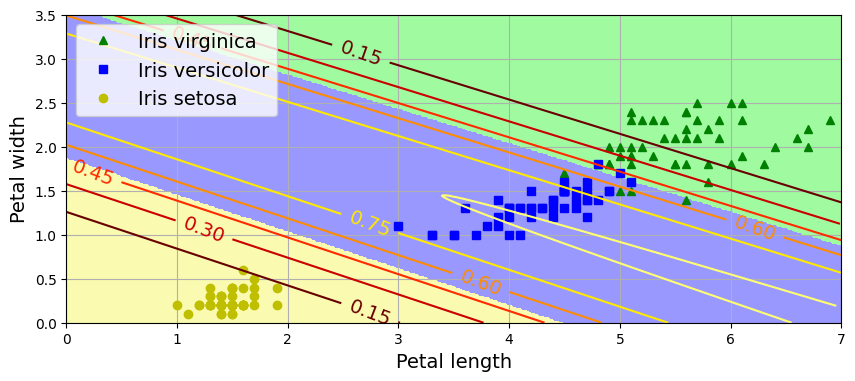

In [ ]:
custom_cmap = mpl.colors.ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - mean) / std
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

logits = X_new_with_bias @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()

And now let's measure the final model's accuracy on the test set:

In [ ]:
logits = X_test @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_test).mean()
accuracy_score

np.float64(0.9666666666666667)

Well we get the same performance on the test set as on the validation set. You will often get slightly worse results on the test set than on the validation set, but not always. It depends on the dataset size and how you sample the training set, validation set and the test set. Try changing the random seed and running the code again a few times, you will see that the results will vary.